# SOP for resonator measurements using mResSweep

Russell McLellan, Aug 16 2022

mResSweep is a module for the ZCU216 model of the RFSOC that is designed to replace a PNAX or other VNA. The module uses up to 4x multiplexed frequency generation and readout to allow for faster measurements.

You will set up a warm system that looks like this:

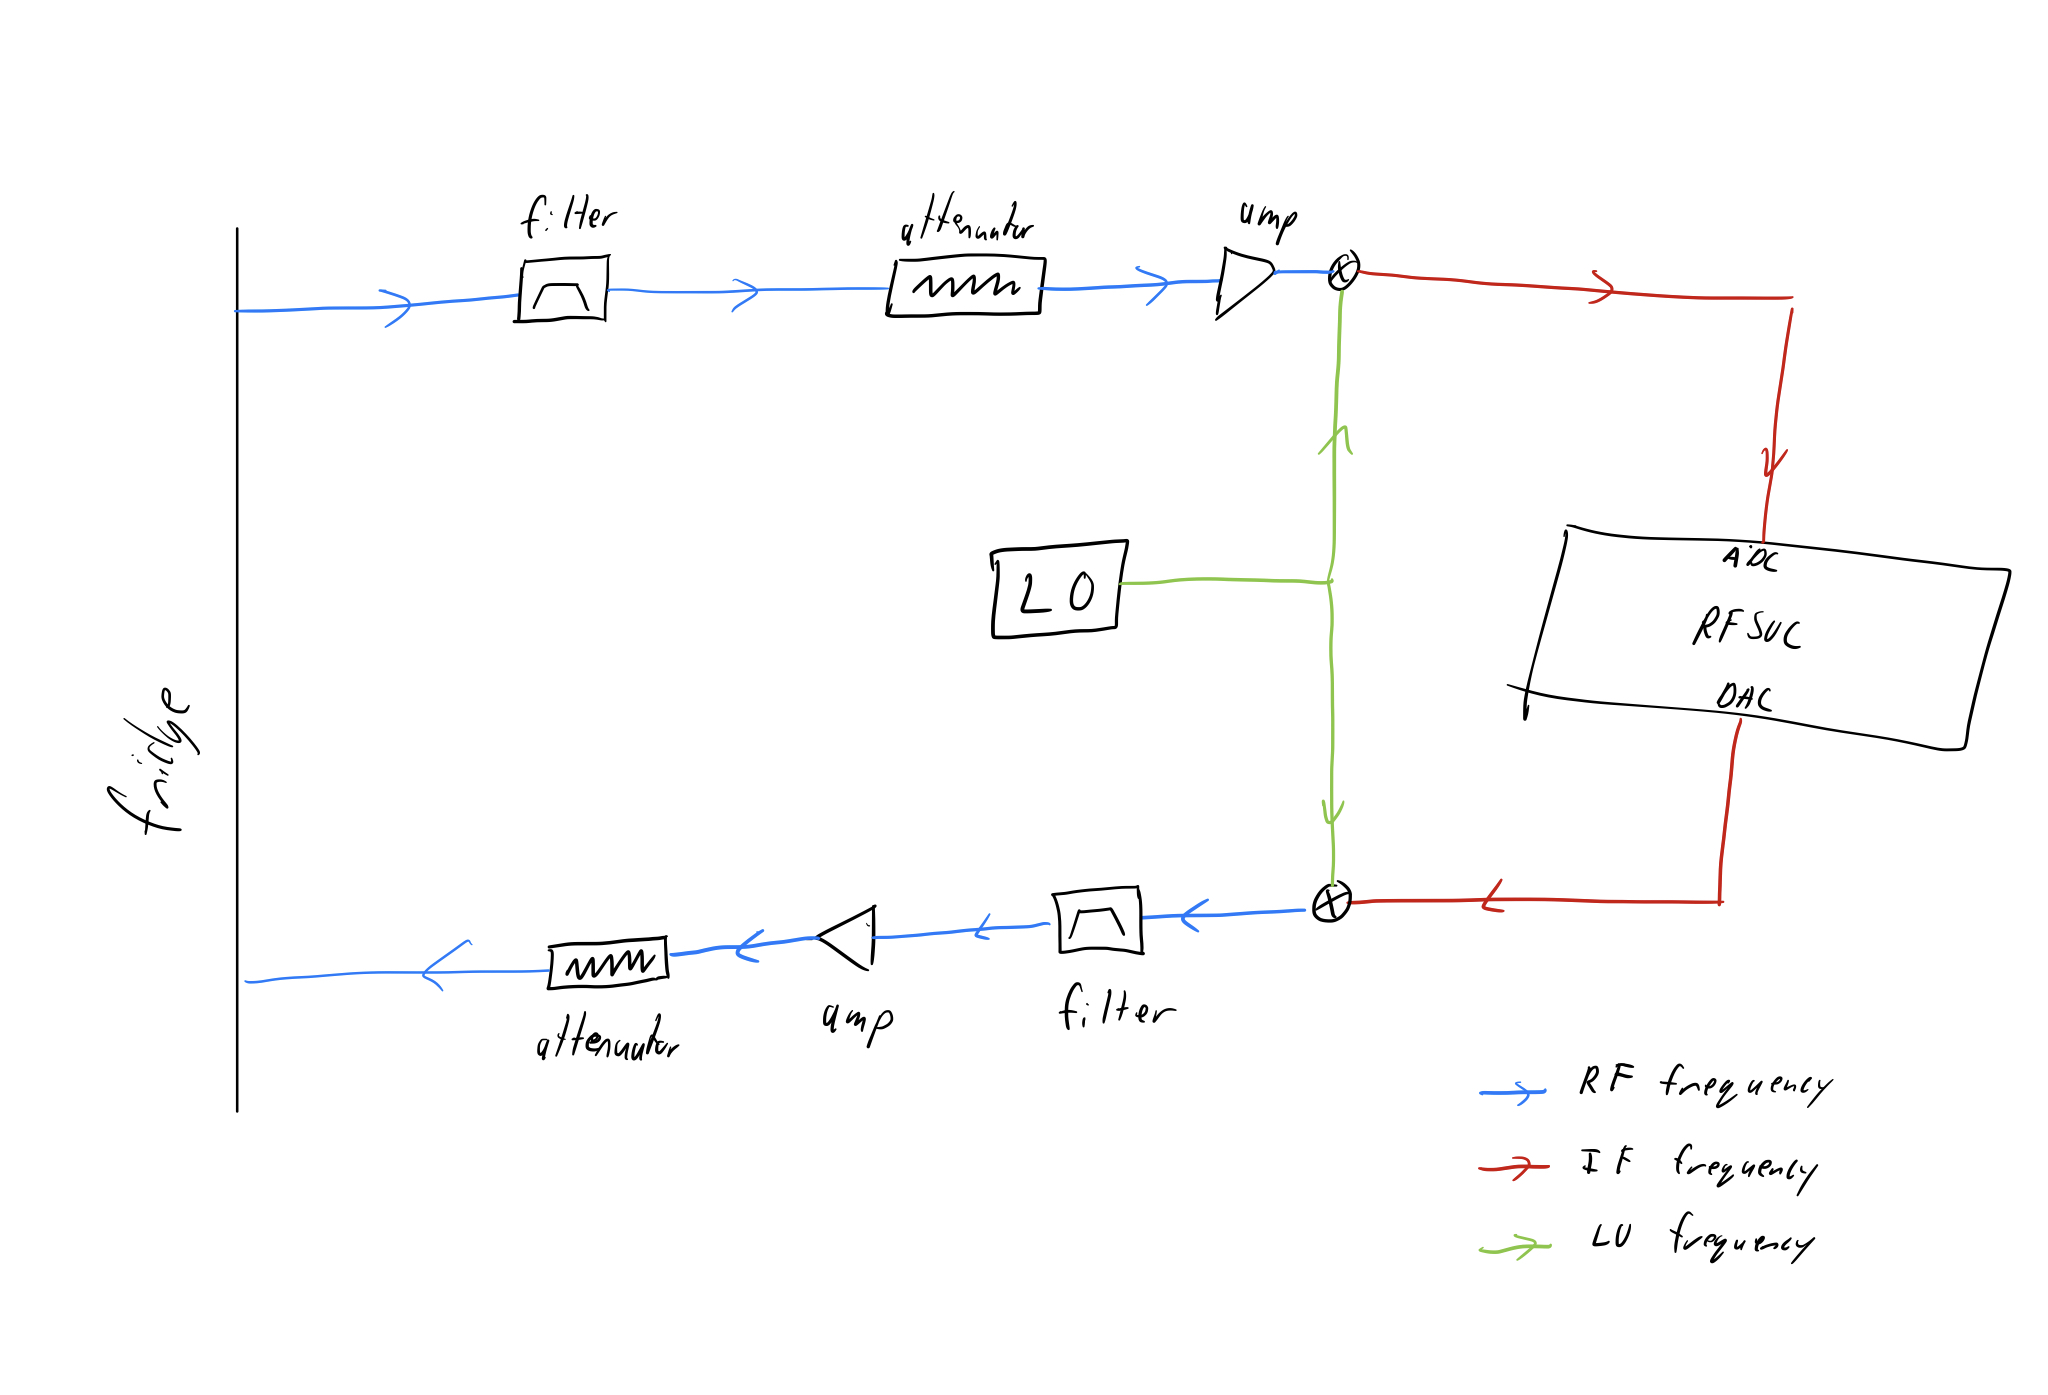

The attenuators are used only for power sweeps. If you only want a sweep at a single power, then amplifiers are probably sufficient.

Considerations:
* The ZCU216 can only read tones that are sufficiently far apart in frequency. With current firmware the spacing is ~350 MHz to guarantee that tones can be read
* The ZCU216 can only input and output certain frequencies from certain ports. As I type this, the board is configured to use 1 to 4 GHz ports (which can also do -1 to -4 GHz).
* The output from the ZCU216 can include many spurious frequencies that will need to be filtered out.
* The maximum input voltage to the ZCU216 is -0.5V to +1.5V.
* At low powers, a long coherent averaging time is needed to beat the white noise threshold.

Below are steps to set up the circuit, find resonators, calibrate the input power, and run a power sweep

## Note on saving data

Calling `mResSweep.ResSweep.save_data(Instance, data)` saves the data collected in `Instance`
* Data is saved in the path denoted by the `path` argument
* The filename will be prefixed by the `prefix` argument
* The filename will have a numeric increment so as not to overwrite old data

Calling `mResSweep.ResSweep.display(Instance, data)` displays and saves a plot from data collected in `Instance`
* It saves with the same filename conventions as `mResSweep.ResSweep.save_data(Instance, data)`

Ensure you have set `path` and `prefix` correctly when initializing `Instance`.

## Connect to the RFSOC

Do these steps if the RFSOC is not already connected to the PC.
1. Connect the RFSOC via ethernet to the computer (probably through a router)
2. Turn on the RFSOC. When facing the SMA ports, there is a left-right switch on the board at the back left
3. Use the IP scanner on the measurement PC to find the board. It will be named 'pynq'
4. Open that IP in a web browser. The password is 'xilinx'
5. Navigate to '\<IP\>/notebooks/ZCU216/pyro4/'
6. In start_nameserver.ipynb:
    1. Copy the pynq IP address into the command
    2. Run the cell
7. In start_server.ipynb:
    1. Change ns_host to `ns_host = <IP>`
    2. Run the cell
8. On each notebook that interfaces with this RFSOC, you will need to copy the IP address into this line: `soc, soccfg = makeProxy(<your IP>)`

The file '/ZCU216/pyro4/Remote_operation_with_Pyro4.ipynb' contains more information on this step, but is not necessary to open or run to connect to the RFSOC.

## Set up the input circuit

0. Get a spectrum analyzer
1. Connect the RFSOC DAC and the LO to a mixer. LO goes in the LO port and RFSOC DAC goes in the IF port.  Split the power from the LO using a power splitter - cap off the unused power output for now, but you will use it in the output circuit. Connect the mixed output to the spectrum analyzer. 
    * NOTE: best practice is to add a 20dB attenuator to the front of the spectrum analyzer if you are uncertain of the power.
2. Set up the LO
    1. Set the LO frequency lower than any resonator frequency. For resonators in the 6-8 GHz range, I have been using 5 GHz. 
    2. Set the LO power to what is needed for the the mixer
    3. Turn the LO power on
3. Choose a frequency in the middle of the expected resonator frequencies. Set up the code to play this frequency constantly.
    1. Use a variant of 'TALE02_SingleSweep.ipynb' to run the tone
    2. Set `inputDict['LO_f'] = <LO frequency in MHz>`
    3. Set the frequency as `inputDict['res_f'] = <your frequency in MHz>`
    4. Set `inputDict['n_reps'] = <some large number>`. The script will repeat that tone n_reps times before stopping
    5. Set `inputDict['span_f'] = 0` to play just the one frequency
4. Add amplifiers and attenenuators after the mixer until the input power is at an acceptable upper bound for a power sweep (eg, 0 dBm)
5. Add filters until spurs are minimized.

Your circuit should now look like this:

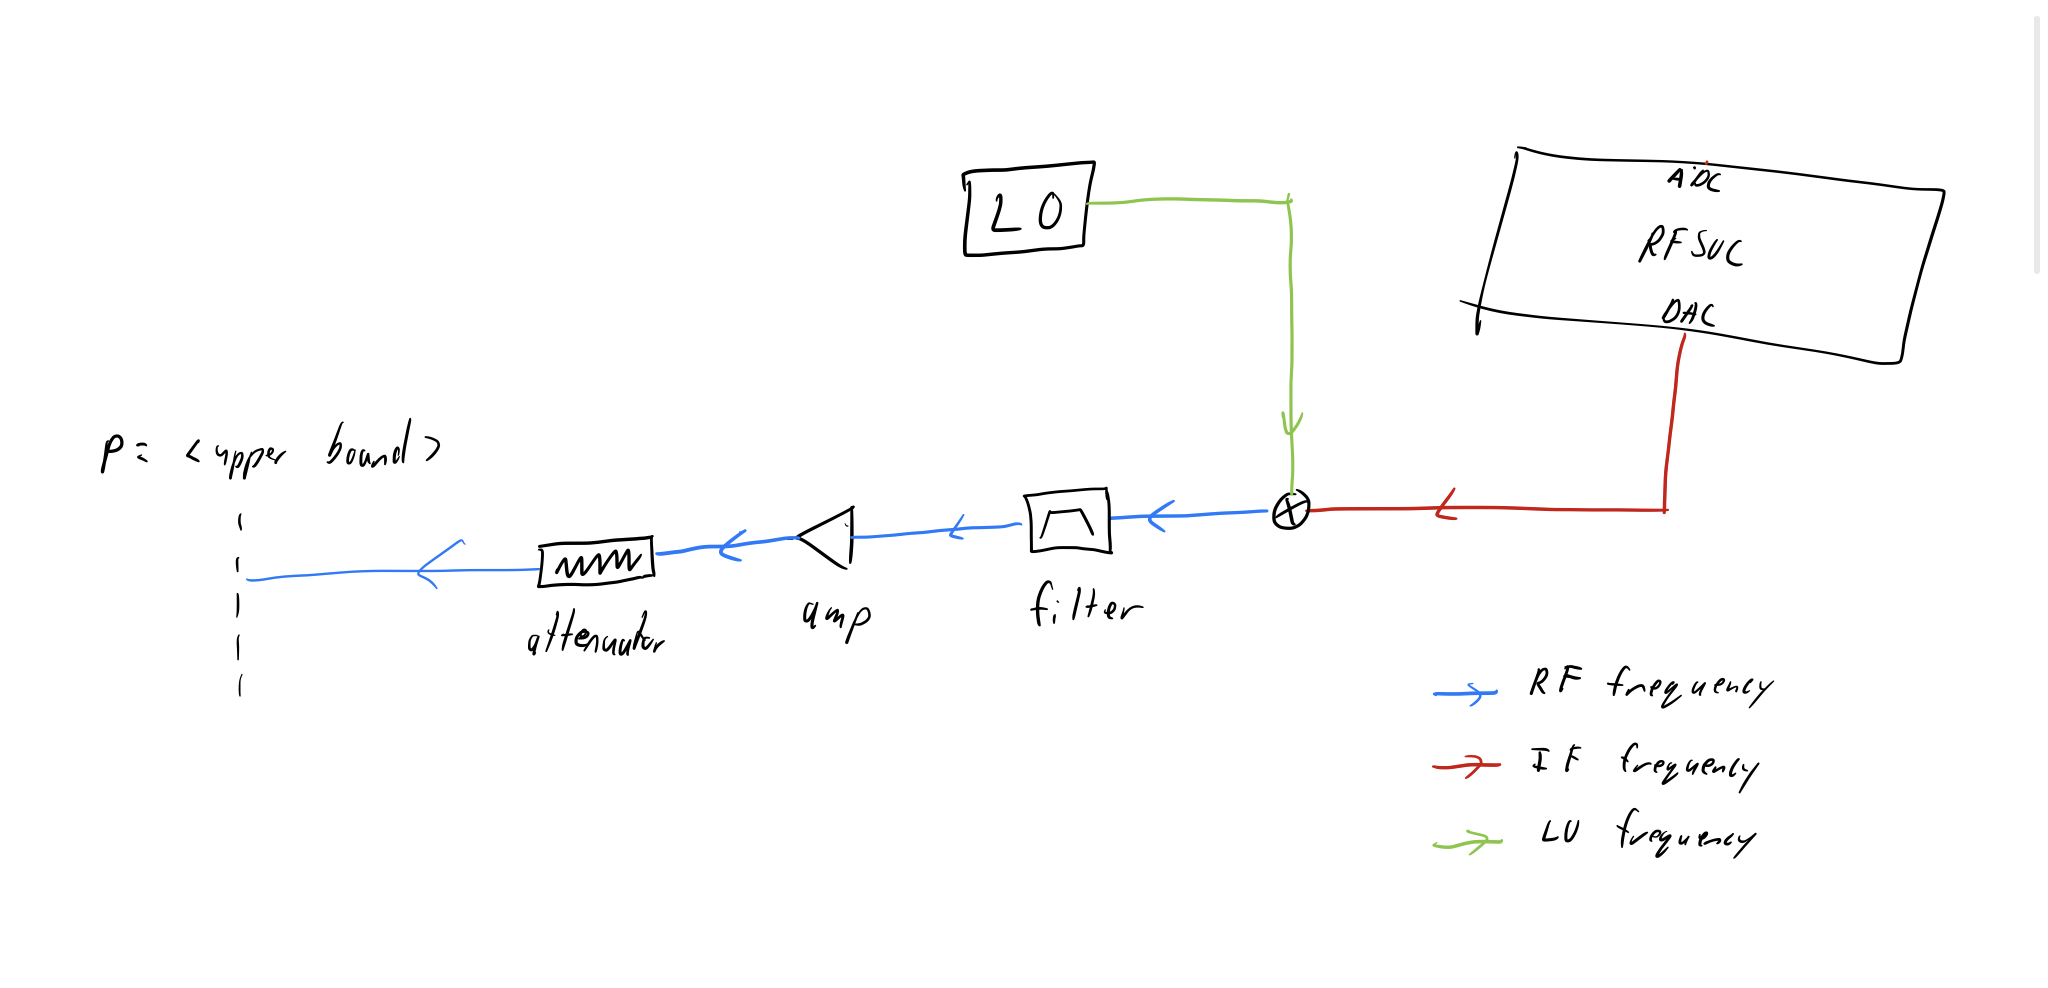

## Find frequencies

1. Connect input circuit to the fridge
2. Connect fridge output to amplifiers until you can measure some power on the spectrum analyzer
3. Calibrate power to ~ -10dBm at the central tone at maximum power by adding amplifiers. Ensure that your amplifiers are not saturated at this power level (check linearity by varying attenuator in Vaunix).
4. Run a wide frequency sweep to find the resonators
    1. Set `inputDict['span'] = <the span you want to sweep>`
    2. Set `inputDict['n_expts'] = <the number of points you want to include>`
    3. `inputDict['n_reps']` can be set low. 10 should be sufficient
5. Set up frequencies for multiplexing
    1. Set `inputDict['res_f'] = [<resonator frequency>, <resonator frequency>, ...]`
    2. Set `inputDict['gains'] = [1,1,1,1]`
    2. Repeatedly run the script, narrowing the span and adjusting the resonator frequency until you have multiplexed readout
    
Note that frequencies must be spaced apart in order for the ZCU216 to read them. The ADC has overlapping channels that are assigned to read certain frequency spans. If more frequencies than channels are available in a small span (ie, more than 2x frequencies in a 312.5 MHz span), the ZCU will throw an error. The channels vs frequencies are shown below. Note that the restriction is on the pulse frequency before the internal mixer, so playing around with `inputDict['mixerCenter_f']` and the LO frequency may cure the error.

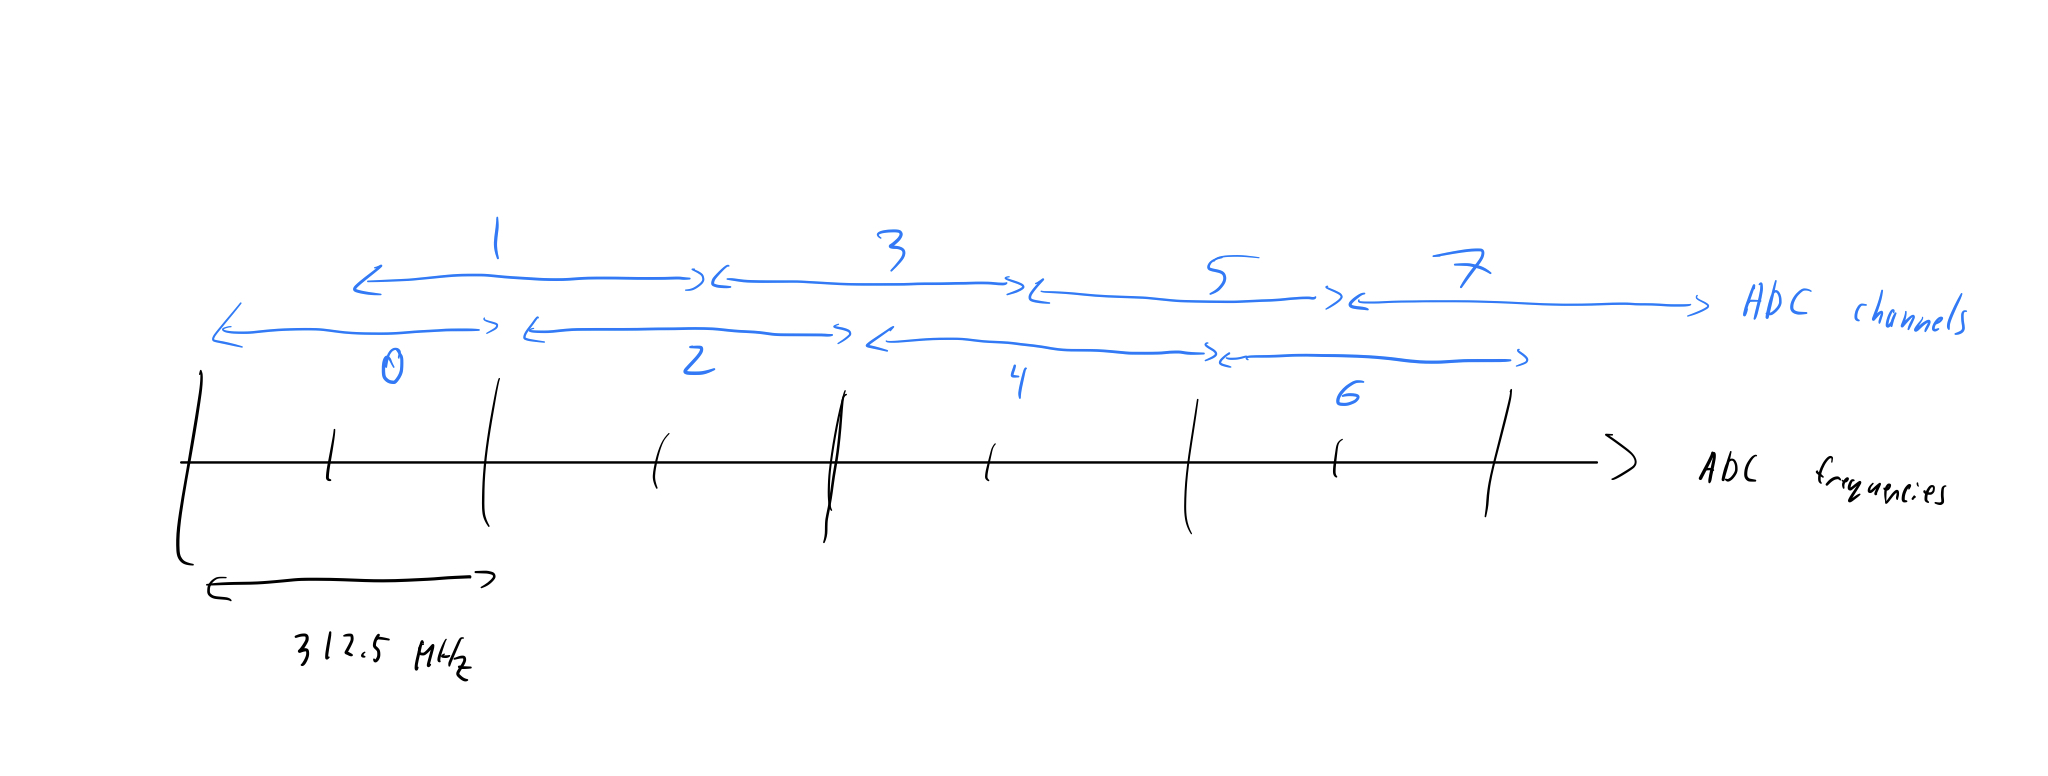

Your circuit should now look like this:

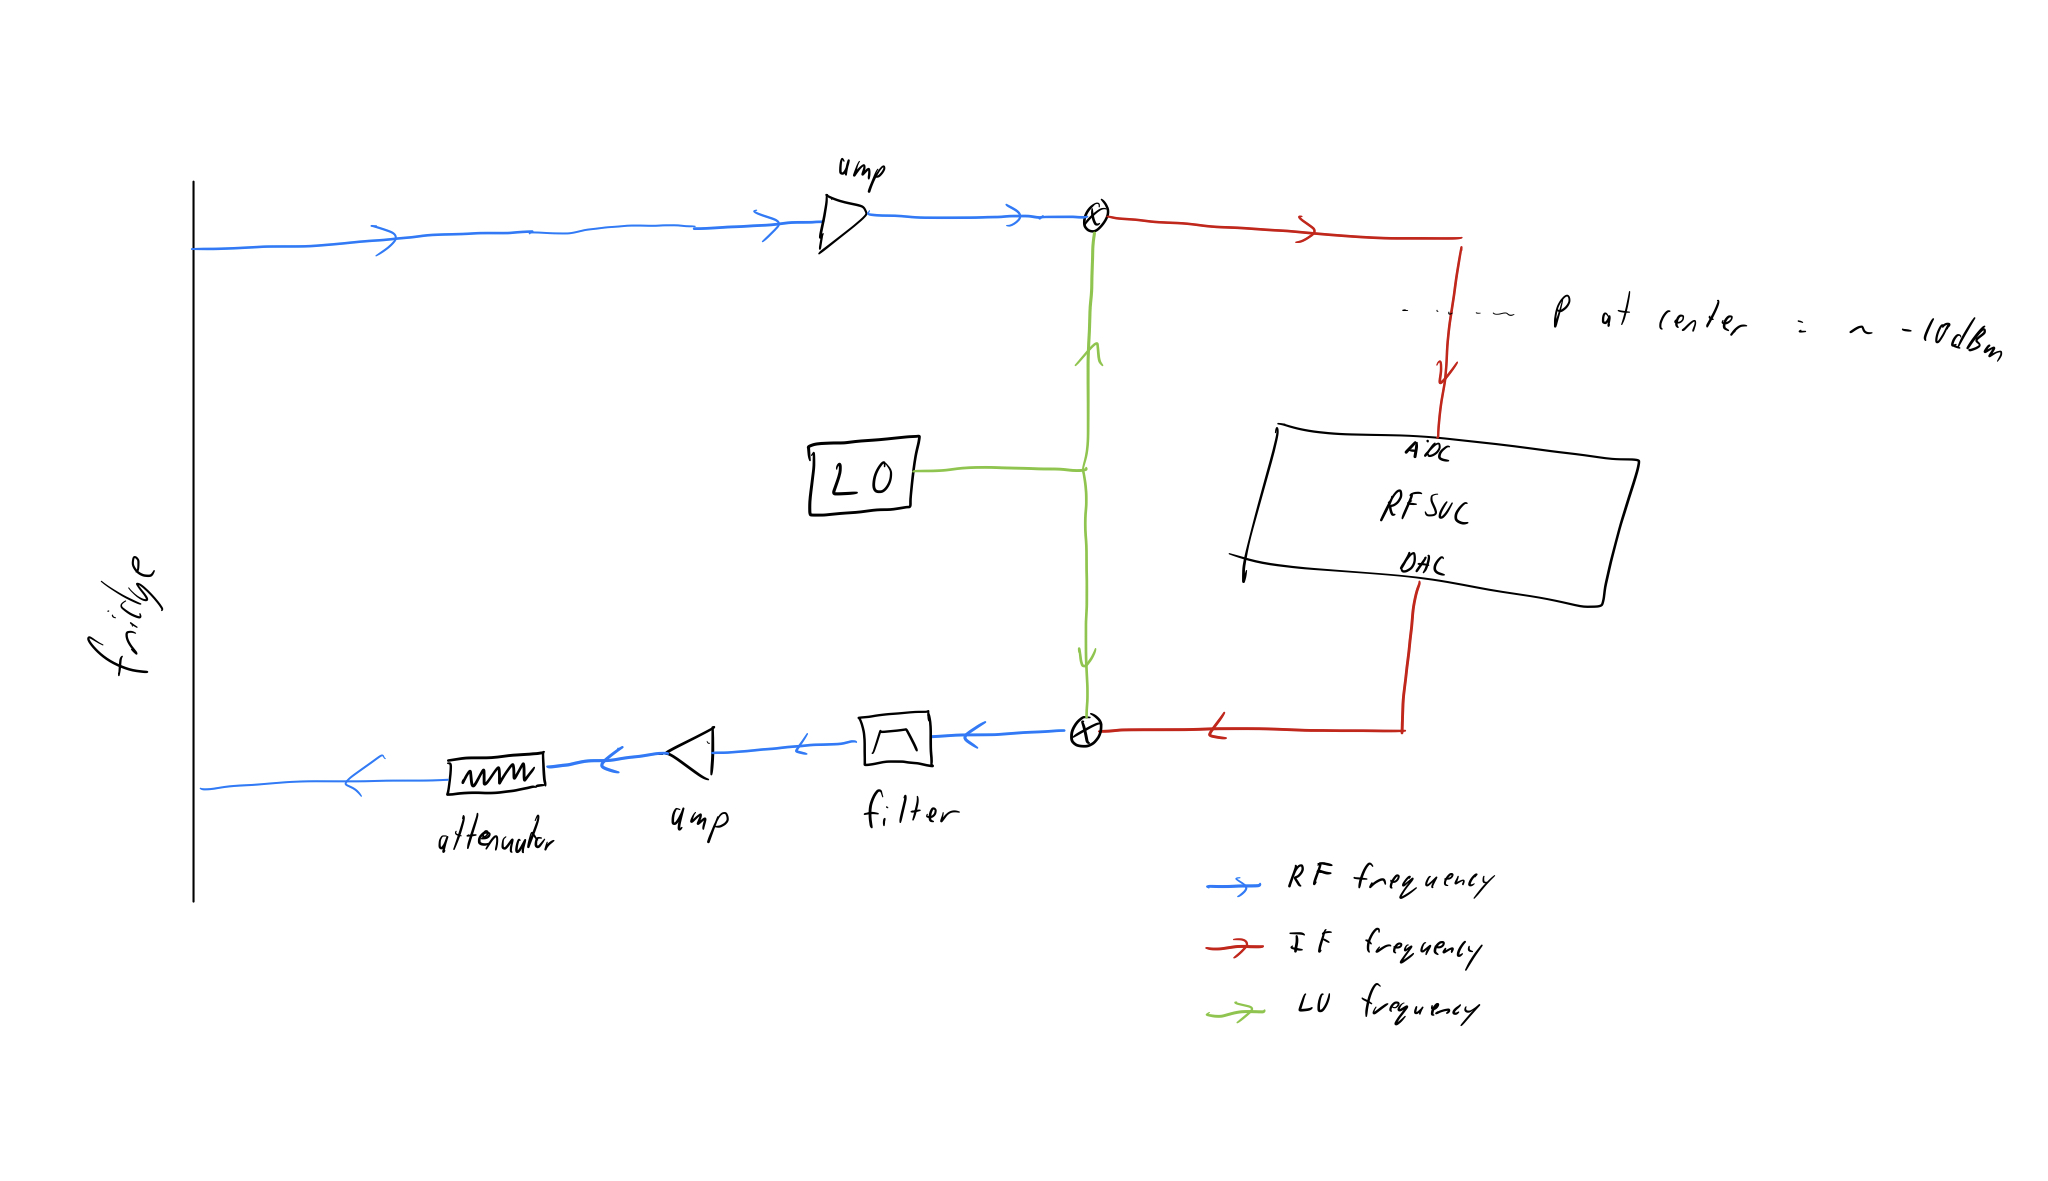

## Calibrate input powers

1. Connect the line going into the fridge input back to the spectrum analyzer
2. Play resonator frequency tones from the ZCU216. Set `inputDict['pulse_freqs']` to the resonator frequencies.
3. Adjust measured powers until you get a constant upper bound for the power sweep. `inputDict['gains']` is a list of linear gains for each channel - adjust these numbers to scale tones relative to each other
4. Record the power at 0 dB input attenuation value in `inputDict['basePower']`

## Calibrate output powers

1. Run the `acquire_decimated` member function of the ResSweep class. Keep `soft_avgs = 1`, which is the default value. This function will return the raw values of the I and Q readout buffers - we will make sure that the counts are larger than the resolution but smaller than the full range.
2. Run `display_decimated` to show the buffers.
3. Add filters, amplifiers, or attenuators to bring the number of counts to about the middle of the ADC limits. You may find that at the lowest powers, you will need more filters and amplifiers to bring the number of counts up.

The image below shows different power levels. Note that while 'mag' is a calculated value, sqrt(I^2 + Q^2), it is the upper bound on what the buffer might measure. It is important that mag stay below the upper bound.

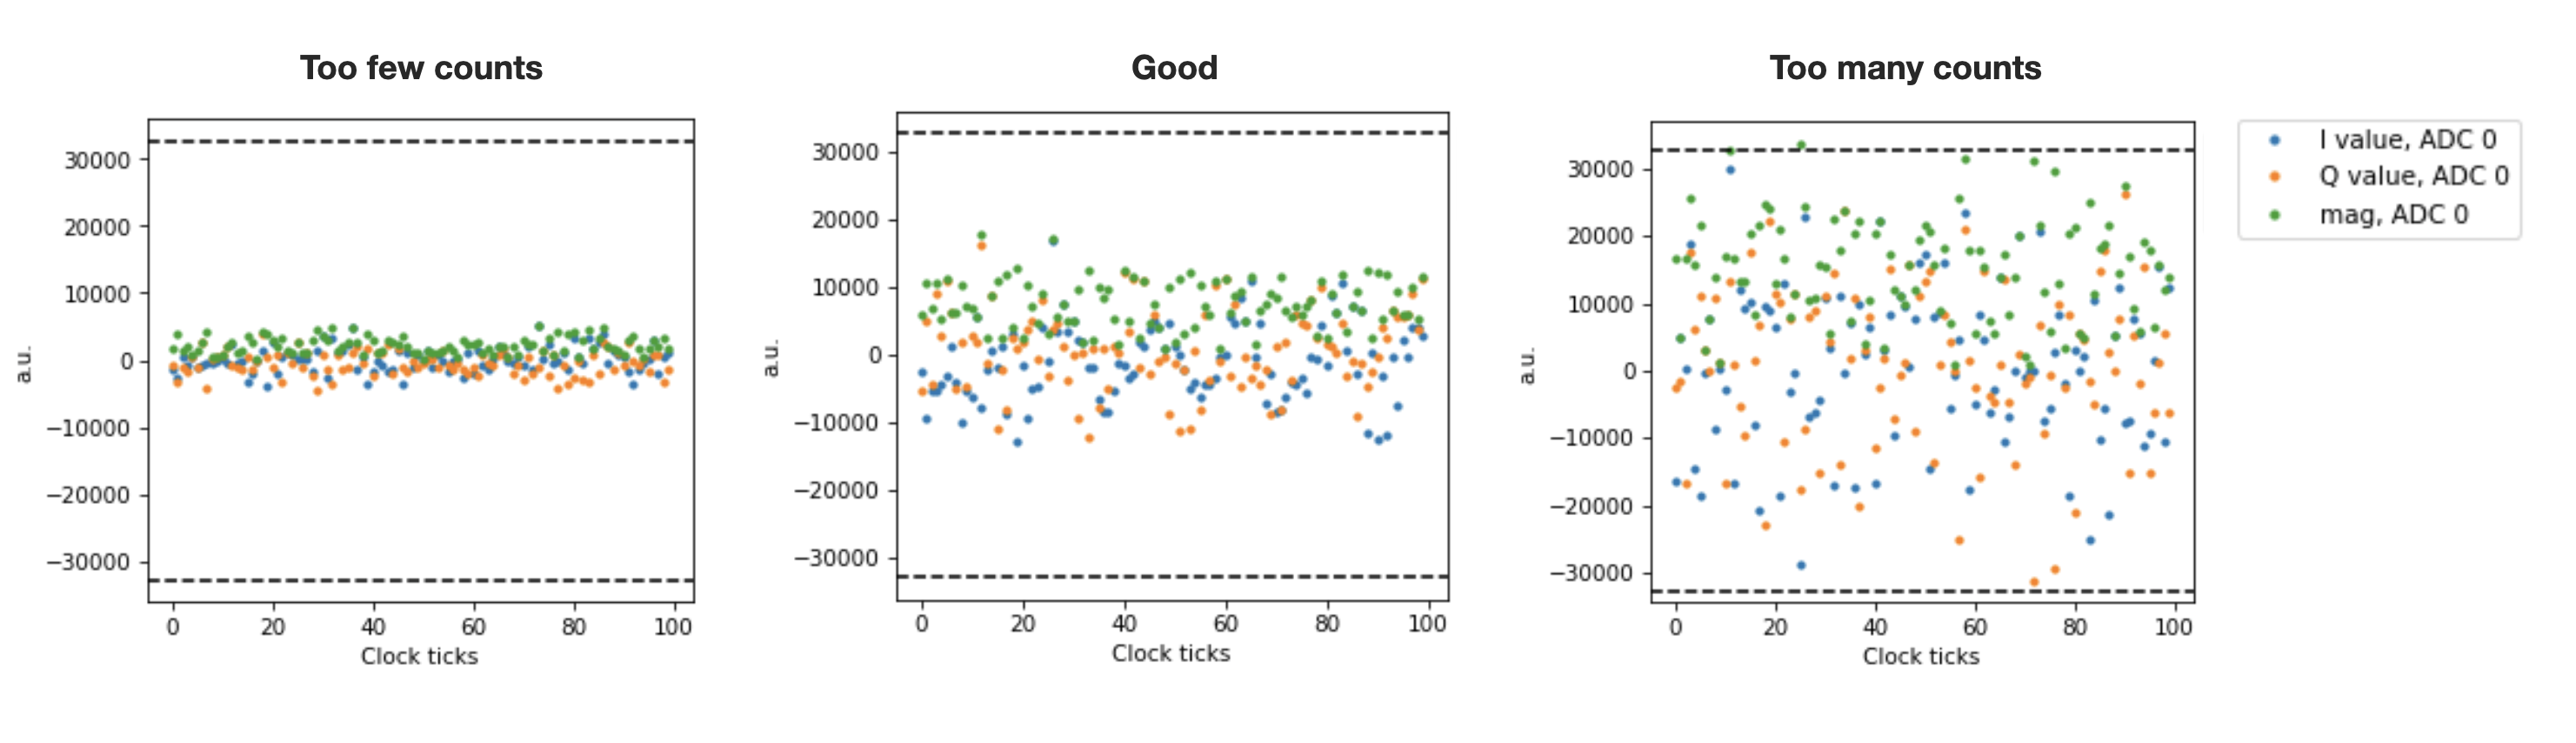

## Set up power sweep

You are responsible for determining if your amplifiers saturate at high powers. You may want to use one 50dB max attenuation lab brick at the output of the circuit, tuned to full attenuation when calibrating output power. When collecting the power sweep, you can turn off the output attenuation after 50dB of input attenuation

1. Find the minimum required resolution bandwidth. 
    1. Plug the off-resonance output (after mixing down) into the spectrum analyzer
    2. Turn the attenuation up until you are inputting the lowest power you think you will sweep
    3. Adjust the spectrum analyzer span until you can resolve the peak
    4. Record the resolution bandwidth at this span
2. Record which attenuator serial numbers you want to use as `inputDict['attenSerial']`
3. Set `inputDict['attenList']`, `inputDict['repsList']`, `inputDict['roundsList']`, and `inputDict['readout_lengthList']` to what you want to sweep.
    1. Note that the resolution bandwidth requirement sets a requirement for low power acquisition - you need reps\*readout_length > 1/(minimum resolution bandwidth). I use 4x the minimum
4. Set `inputDict['ring_up_time']` to several times the ring up time of the cavity
5. Set `inputDict['ring_between_time']` to a fraction of `inputDict['ring_up_time']`. I have been using 1/10, but I don't know if that is optimal.
5. Press play!